# Programming Assignment 1

Author: Mao Nishino

## Data Preparation

In [53]:
import torch
import matplotlib.pyplot as plt

# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

def load_data(path: str):
    """ Load the data and make a list of (index, data tensor).
    Args:   
        path: the path of the file to read  the data from.
    Returns:
        data_list: a list of tuples, each tuple contains the index of the data and the data tensor.
    """
    with open(path) as file:
        lines = file.readlines()

    float_lines = [[float(string) for string in line.split()] for line in lines]
    data_list = [(torch.tensor(line[1:]).reshape(1,16,16), int(line[0])) for line in float_lines]
    return data_list

train_list = load_data('../zip_train.txt')
test_list = load_data('../zip_test.txt')

print(f"Loaded {len(train_list)} data for train data")
print(f"Loaded {len(test_list)} data for train data")

# Define PyTorch Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

# Create PyTorch Dataset
train_dataset = MyDataset(train_list)
test_dataset = MyDataset(test_list)

# Split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Using cuda device
Loaded 7291 data for train data
Loaded 2007 data for train data


In [4]:
import random

# Define a 4 layer ReLU neural network

class NeuralNetwork(torch.nn.Module):
    def __init__(self, n1, n2, n3, activations):
        """ Define the layers of the neural network.
        
        Args:
            n1: the number of neurons in the first layer.
            n2: the number of neurons in the second layer.
            n3: the number of neurons in the third layer.
            activations: a list of strings, each string is the name of the activation function to use in the corresponding layer.
            """
        
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.activation_functions = {
            "relu": torch.nn.ReLU(),
            "sigmoid": torch.nn.Sigmoid()
        }
        self.layer1 = torch.nn.Linear(256, n1)
        self.layer2 = torch.nn.Linear(n1, n2)
        self.layer3 = torch.nn.Linear(n2, n3)
        self.layer4 = torch.nn.Linear(n3, 10)

        self.activations = torch.nn.ModuleList([self.activation_functions[activation] for activation in activations])


    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.activations[0](x)
        x = self.layer2(x)
        x = self.activations[1](x)
        x = self.layer3(x)
        x = self.activations[2](x)
        x = self.layer4(x)
        x = self.activations[3](x)
        return x

# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model - This corresponds to 1 epoch
# We also collect the training loss
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Record the loss
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Return the average loss
    return sum(losses)/size
        


# Test the model
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    return correct

def random_search_4layerReLU():
    """ Random search for 4 layer ReLU neural network hyperparameters.

    We will employ the "coarse to fine" strategy on the number of neurons in each layer.
    At the beginning, each layer will have a range of 10 to 2024 neurons. 
    Then, we will reduce the range to 10 to the best number of neurons found in the previous iteration so that we can find the best number of neurons in a smaller range.
    Moreover, we will double the number of samples, +10 the epochs, and half the batch size in each iteration to get a more accurate result.
    
    """
    best_accuracy = 0
    best_n = [1024, 1024, 1024]
    new_best_n = best_n
    samples = 200
    epochs = 5
    batch_size = 32

    for _ in range(3):
        # Create dataloaders
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        for _ in range(samples):
            n3 = torch.randint(10, max(best_n[2],11), (1,)).item()
            n2 = torch.randint(n3, max(best_n[1],11), (1,)).item()
            n1 = torch.randint(n2, max(best_n[0],11), (1,)).item()

            activation_options = ['relu'] 
            activations = [random.choice(activation_options) for _ in range(4)]

            model = NeuralNetwork(n1, n2, n3, activations).to(device)
            optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # Fixed learning rate for simplicity

            for epoch in range(epochs):
                train(train_dataloader, model, loss_fn, optimizer)
            
            accuracy = test(val_dataloader, model, loss_fn)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                new_best_n = [n1, n2, n3]
                print(f"Best (n1, n2, n3): {new_best_n}, Best Activations: {activations}, Accuracy: {(100*best_accuracy):>0.1f}%")
                print(f"Epochs: {epochs}, Batch size: {batch_size}")
        best_n = new_best_n

        samples //= 2
        epochs += 10
        batch_size //= 2
        print(f"Now the best n is {best_n} and the number of samples is {samples} and the number of epochs is {epochs} and the batch size is {batch_size}")

# random_search_4layerReLU()

# Locally Connected NN Architecture

In [103]:
class LocallyConnected2D(torch.nn.Module):
    """ Defines a locally connected layer. Basically it is a convolutional layer without weight sharing.

    Args:
        in_channels: the number of input channels.
        out_channels: the number of output channels.
        output_size: (H, W) of the output tensor.
        kernel_size: the size of the kernel.
        stride: the stride of the kernel.

        For an input tensor of shape (N, C, H, W), the output tensor will have the shape \
              (N, out_channels, output_size[0], output_size[1]).
    """
    def __init__(self, in_channels, out_channels, output_size, kernel_size, stride=1):
        super(LocallyConnected2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = torch.nn.modules.utils._pair(kernel_size)
        self.stride = torch.nn.modules.utils._pair(stride)
        self.output_size = output_size
        self.weight = torch.nn.Parameter(
            torch.randn(out_channels, in_channels*kernel_size**2, output_size[0]*output_size[1])
        )
        self.bias = torch.nn.Parameter(torch.randn(out_channels, output_size[0]*output_size[1]))
      
    def forward(self, x):
      kH, kW = self.kernel_size
      sH, sW = self.stride
      n, _, _, _ = x.shape
      x = torch.nn.functional.unfold(x, (kH, kW), (sH, sW))
      x = x.unsqueeze(dim=1)*self.weight.unsqueeze(dim=0)
      x = x.sum(dim=2)
      x = x + self.bias.unsqueeze(dim=0)
      x = torch.nn.functional.fold(x, self.output_size, (sH, sW))
      return x.reshape(n, self.out_channels, self.output_size[0], self.output_size[1])
    
def output_size_calc(H_in, W_in, kernel_size, stride = 1):
    """ Calculate the output size of a locally connected layer.

    Args:
            H_in: the height of the input tensor.
            W_in: the width of the input tensor.
            kernel_size: the size of the kernel.
            stride: the stride of the kernel.

    Returns:
        H_out: the height of the output tensor.
        W_out: the width of the output tensor.

    We use the formula
    H_out = (H_in - kernel_size) // stride + 1
    W_out = (W_in - kernel_size) // stride + 1
    """
    H_out = (H_in - kernel_size) // stride + 1
    W_out = (W_in - kernel_size) // stride + 1
    return H_out, W_out

# Mimic the convolutional neural network by locally connected layers

class LocallyConnectedNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(LocallyConnectedNeuralNetwork, self).__init__()
        self.conv1 = LocallyConnected2D(in_channels=1, out_channels=4, kernel_size=5, output_size=output_size_calc(16, 16, 5))
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=1)
        insize_conv2 = output_size_calc(*output_size_calc(16, 16, 5), 2)
        self.conv2 = LocallyConnected2D(in_channels=4, out_channels=12, kernel_size=3, output_size=output_size_calc(*insize_conv2, 3))
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(12*4*4, 84)
        self.fc2 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 12*4*4)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [104]:
# Train the locally connected neural network

epochs = 30
batch_size = 8

model = LocallyConnectedNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # Fixed learning rate for simplicity
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy = test(val_dataloader, model, loss_fn)
    print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {(100*accuracy):>0.1f}%")

Epoch [1/30], Accuracy: 23.5%
Epoch [2/30], Accuracy: 67.9%
Epoch [3/30], Accuracy: 79.5%
Epoch [4/30], Accuracy: 82.1%
Epoch [5/30], Accuracy: 85.4%
Epoch [6/30], Accuracy: 86.8%
Epoch [7/30], Accuracy: 85.3%
Epoch [8/30], Accuracy: 86.3%
Epoch [9/30], Accuracy: 74.6%
Epoch [10/30], Accuracy: 86.7%
Epoch [11/30], Accuracy: 89.2%
Epoch [12/30], Accuracy: 89.3%
Epoch [13/30], Accuracy: 89.3%
Epoch [14/30], Accuracy: 89.5%
Epoch [15/30], Accuracy: 88.6%
Epoch [16/30], Accuracy: 90.2%
Epoch [17/30], Accuracy: 90.7%
Epoch [18/30], Accuracy: 88.6%
Epoch [19/30], Accuracy: 90.3%
Epoch [20/30], Accuracy: 90.7%
Epoch [21/30], Accuracy: 87.7%
Epoch [22/30], Accuracy: 91.2%
Epoch [23/30], Accuracy: 90.3%
Epoch [24/30], Accuracy: 90.8%
Epoch [25/30], Accuracy: 91.2%
Epoch [26/30], Accuracy: 91.8%
Epoch [27/30], Accuracy: 89.7%
Epoch [28/30], Accuracy: 92.4%
Epoch [29/30], Accuracy: 91.0%
Epoch [30/30], Accuracy: 91.9%


# Convolutional NN Architecture

In [134]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=12, kernel_size=3)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(12*4*4, 84)
        self.fc2 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 12*4*4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

In [32]:
# Train the convolutional neural network

epochs = 30
batch_size = 8

model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # Fixed learning rate for simplicity
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    accuracy = test(val_dataloader, model, loss_fn)
    print(f"Epoch [{epoch+1}/{epochs}], Accuracy: {(100*accuracy):>0.1f}%")

Epoch [1/30], Accuracy: 65.0%
Epoch [2/30], Accuracy: 79.0%
Epoch [3/30], Accuracy: 83.1%
Epoch [4/30], Accuracy: 84.9%
Epoch [5/30], Accuracy: 85.8%
Epoch [6/30], Accuracy: 87.5%
Epoch [7/30], Accuracy: 88.8%
Epoch [8/30], Accuracy: 89.0%
Epoch [9/30], Accuracy: 89.4%
Epoch [10/30], Accuracy: 89.2%
Epoch [11/30], Accuracy: 89.0%
Epoch [12/30], Accuracy: 88.8%
Epoch [13/30], Accuracy: 89.2%
Epoch [14/30], Accuracy: 89.2%
Epoch [15/30], Accuracy: 89.8%
Epoch [16/30], Accuracy: 89.8%
Epoch [17/30], Accuracy: 89.7%
Epoch [18/30], Accuracy: 97.0%
Epoch [19/30], Accuracy: 97.1%
Epoch [20/30], Accuracy: 97.7%
Epoch [21/30], Accuracy: 97.2%
Epoch [22/30], Accuracy: 97.3%
Epoch [23/30], Accuracy: 97.6%
Epoch [24/30], Accuracy: 97.9%
Epoch [25/30], Accuracy: 97.6%
Epoch [26/30], Accuracy: 97.5%
Epoch [27/30], Accuracy: 97.8%
Epoch [28/30], Accuracy: 97.5%
Epoch [29/30], Accuracy: 97.9%
Epoch [30/30], Accuracy: 97.7%


# Task 2: Techniques for Optimization

## Parameter Initialization Techniques

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


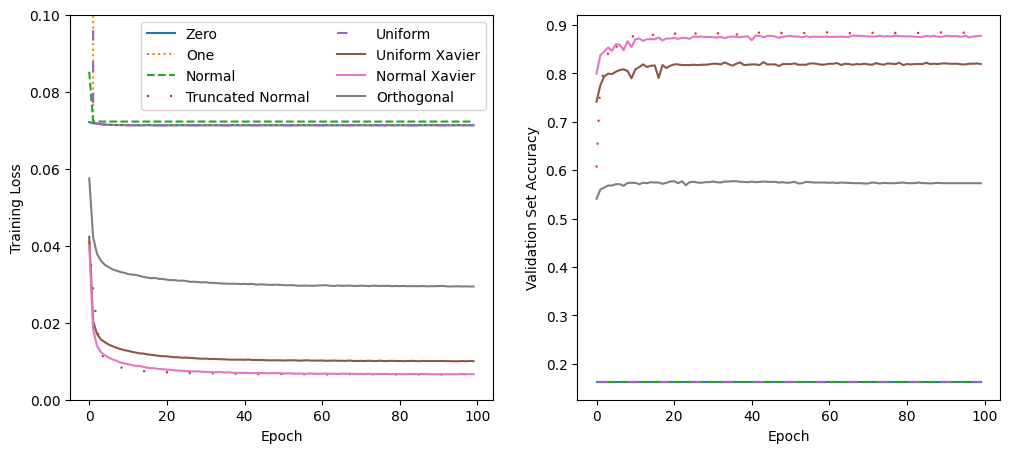

In [139]:
"""
We will compare the training loss at each epoch for the following cases:
1. Zero initialization
2. One initialization
3. Normal Initialization
4. Uniform Initialization
5. Uniform Xavier initialization
6. Normal Xavier initialization
7. Truncated normal initialization
8. Orthogonal initialization

We start from the fully connected NN.

For all biases, we will initialize them to 0.01.
"""
LEARN_RATE = 1e-2
BATCH_SIZE = 32
EPOCHS = 100

def initialize_and_train_fc(model, init_func, train_dataloader, val_dataloader, epochs, **init_params):
    """ Initialize the model and train it.

    Args:
        model: the model to train.
        loss_fn: the loss function to use.
        init_strat: the initialization function to use. It should take a model parameter as input and initialize it in place.
        train_dataloader: the dataloader for the training dataset.
        val_dataloader: the dataloader for the validation dataset.
        optimizer: the optimizer to use.
        epochs: the number of epochs to train the model.
        **init_params: the parameters to pass to the initialization function.

    Returns:
        loss: the training loss at each epoch.
        accuracy: the accuracy at each epoch.
    """
    init_func(model.layer1.weight, **init_params)
    init_func(model.layer2.weight, **init_params)
    init_func(model.layer3.weight, **init_params)
    init_func(model.layer4.weight, **init_params)

    model.layer1.bias.data.fill_(0.01)
    model.layer2.bias.data.fill_(0.01)
    model.layer3.bias.data.fill_(0.01)
    model.layer4.bias.data.fill_(0.01)

    loss = []
    accuracy = []

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARN_RATE) # Fixed learning rate for simplicity

    for epoch in range(epochs):
        loss.append(train(train_dataloader, model, loss_fn, optimizer))
        accuracy.append(test(val_dataloader, model, loss_fn))
    return loss, accuracy

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Zero initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
zero_loss, zero_accuracy = initialize_and_train_fc(model, torch.nn.init.zeros_, train_dataloader, val_dataloader, EPOCHS)

# One initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
one_loss, one_accuracy = initialize_and_train_fc(model, torch.nn.init.ones_, train_dataloader, val_dataloader, EPOCHS)

# Normal Initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
normal_loss, normal_accuracy = initialize_and_train_fc(model, torch.nn.init.normal_, train_dataloader, val_dataloader, EPOCHS, std=0.1)

# Truncated normal initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
truncated_normal_loss, truncated_normal_accuracy = initialize_and_train_fc(model, torch.nn.init.trunc_normal_, train_dataloader, val_dataloader, EPOCHS, a=-0.1, b=0.1)

# Uniform Initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
uniform_loss, uniform_accuracy = initialize_and_train_fc(model, torch.nn.init.uniform_, train_dataloader, val_dataloader, EPOCHS)

# Uniform Xavier initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
uniform_xavier_loss, uniform_xavier_accuracy = initialize_and_train_fc(model, torch.nn.init.xavier_uniform_, train_dataloader, val_dataloader, EPOCHS)

# Normal Xavier initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
normal_xavier_loss, normal_xavier_accuracy = initialize_and_train_fc(model, torch.nn.init.xavier_normal_, train_dataloader, val_dataloader, EPOCHS)

# Orthogonal initialization
model = NeuralNetwork(778, 761, 737, ["relu", "relu", "relu", "relu"]).to(device)
orthogonal_loss, orthogonal_accuracy = initialize_and_train_fc(model, torch.nn.init.orthogonal_, train_dataloader, val_dataloader, EPOCHS)

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(zero_loss, label="Zero")
ax[0].plot(one_loss, label="One", linestyle='dotted')
ax[0].plot(normal_loss, label="Normal", linestyle='dashed')
ax[0].plot(truncated_normal_loss, label="Truncated Normal", linestyle=(0,(1,10)))
ax[0].plot(uniform_loss, label="Uniform", linestyle=(0,(5,10)))
ax[0].plot(uniform_xavier_loss, label="Uniform Xavier")
ax[0].plot(normal_xavier_loss, label="Normal Xavier")
ax[0].plot(orthogonal_loss, label="Orthogonal")
ax[0].set_xlabel("Epoch")
ax[0].set_ylim([0.0, 0.1])
ax[0].set_ylabel("Training Loss")
ax[0].legend(ncol=2)

ax[1].plot(zero_accuracy, label="Zero")
ax[1].plot(one_accuracy, label="One", linestyle='dotted')
ax[1].plot(normal_accuracy, label="Normal", linestyle='dashed')
ax[1].plot(truncated_normal_accuracy, label="Truncated Normal", linestyle=(0,(1,10)))
ax[1].plot(uniform_accuracy, label="Uniform", linestyle=(0,(5,10)))
ax[1].plot(uniform_xavier_accuracy, label="Uniform Xavier")
ax[1].plot(normal_xavier_accuracy, label="Normal Xavier")
ax[1].plot(orthogonal_accuracy, label="Orthogonal")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Set Accuracy")
# ax[1].legend(ncol=3, bbox_to_anchor=(0.5,0.3), loc='center')
#plt.show()
plt.savefig('../initialization_comparison.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


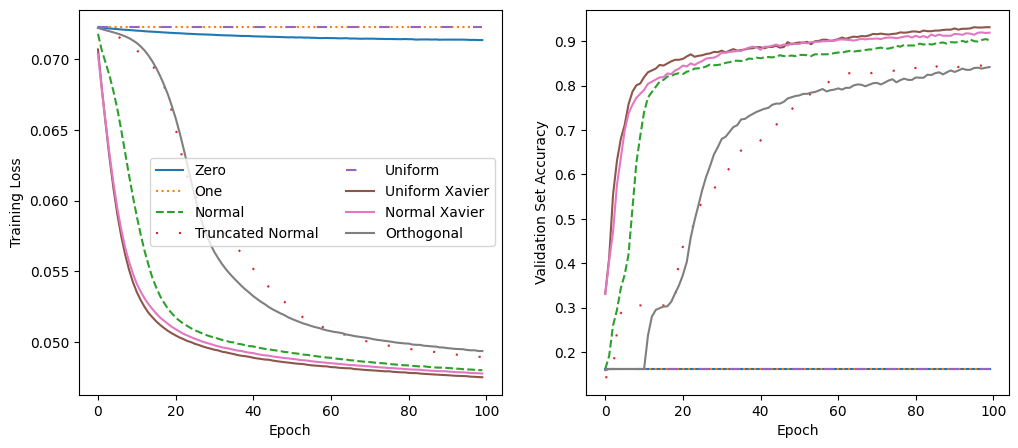

In [141]:
"""
We will work on the locally connected neural network.
"""

import math
LEARN_RATE = 1e-2
BATCH_SIZE = 32
EPOCHS = 100

# We implement Uniform Xavier and Normal Xavier initialization for locally connected layers.

def uniform_xavier_lc(weight, layer: LocallyConnected2D):
    """ Uniform Xavier initialization for locally connected layers.

    Args:
        layer: the locally connected layer to initialize.
    """
    n_in = layer.in_channels*layer.kernel_size[0]*layer.kernel_size[1]
    n_out = layer.out_channels*layer.kernel_size[0]*layer.kernel_size[1]
    std = math.sqrt(6/(n_in + n_out))
    weight.data.uniform_(-std, std)

def normal_xavier_lc(weight, layer: LocallyConnected2D):
    """ Normal Xavier initialization for locally connected layers.

    Args:
        layer: the locally connected layer to initialize.
    """
    n_in = layer.in_channels*layer.kernel_size[0]*layer.kernel_size[1]
    n_out = layer.out_channels*layer.kernel_size[0]*layer.kernel_size[1]
    std = math.sqrt(2./(n_in + n_out))
    weight.data.normal_(0, std)

def initialize_and_train_lc(model, init_func, train_dataloader, val_dataloader, epochs, **init_params):
    """ Initialize the model and train it.

    Args:
        model: the model to train.
        loss_fn: the loss function to use.
        init_strat: the initialization function to use. It should take a model parameter as input and initialize it in place.
        train_dataloader: the dataloader for the training dataset.
        val_dataloader: the dataloader for the validation dataset.
        optimizer: the optimizer to use.
        epochs: the number of epochs to train the model.
        **init_params: the parameters to pass to the initialization function.

    Returns:
        loss: the training loss at each epoch.
        accuracy: the accuracy at each epoch.
    """
    if init_func == uniform_xavier_lc:
        init_func(model.conv1.weight, model.conv1)
        init_func(model.conv2.weight, model.conv2)
        torch.nn.init.xavier_uniform_(model.fc1.weight)
        torch.nn.init.xavier_uniform_(model.fc2.weight)
    elif init_func == normal_xavier_lc:
        init_func(model.conv1.weight, model.conv1)
        init_func(model.conv2.weight, model.conv2)
        torch.nn.init.xavier_normal_(model.fc1.weight)
        torch.nn.init.xavier_normal_(model.fc2.weight)
    else:
        init_func(model.conv1.weight, **init_params)
        init_func(model.conv2.weight, **init_params)
        init_func(model.fc1.weight, **init_params)
        init_func(model.fc2.weight, **init_params)

    model.conv1.bias.data.fill_(0.01)
    model.conv2.bias.data.fill_(0.01)
    model.fc1.bias.data.fill_(0.01)
    model.fc2.bias.data.fill_(0.01)

    loss = []
    accuracy = []

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARN_RATE) # Fixed learning rate for simplicity

    for epoch in range(epochs):
        loss.append(train(train_dataloader, model, loss_fn, optimizer))
        accuracy.append(test(val_dataloader, model, loss_fn))
    return loss, accuracy

# Zero initialization
model = LocallyConnectedNeuralNetwork().to(device)
zero_loss, zero_accuracy = initialize_and_train_lc(model, torch.nn.init.zeros_, train_dataloader, val_dataloader, EPOCHS)

# One initialization
model = LocallyConnectedNeuralNetwork().to(device)
one_loss, one_accuracy = initialize_and_train_lc(model, torch.nn.init.ones_, train_dataloader, val_dataloader, EPOCHS)

# Normal Initialization
model = LocallyConnectedNeuralNetwork().to(device)
normal_loss, normal_accuracy = initialize_and_train_lc(model, torch.nn.init.normal_, train_dataloader, val_dataloader, EPOCHS, std=0.1)

# Truncated normal initialization
model = LocallyConnectedNeuralNetwork().to(device)
truncated_normal_loss, truncated_normal_accuracy = initialize_and_train_lc(model, torch.nn.init.trunc_normal_, train_dataloader, val_dataloader, EPOCHS, a=-0.1, b=0.1)

# Uniform Initialization
model = LocallyConnectedNeuralNetwork().to(device)
uniform_loss, uniform_accuracy = initialize_and_train_lc(model, torch.nn.init.uniform_, train_dataloader, val_dataloader, EPOCHS)

# Uniform Xavier initialization
model = LocallyConnectedNeuralNetwork().to(device)
uniform_xavier_loss, uniform_xavier_accuracy = initialize_and_train_lc(model, uniform_xavier_lc, train_dataloader, val_dataloader, EPOCHS)

# Normal Xavier initialization
model = LocallyConnectedNeuralNetwork().to(device)
normal_xavier_loss, normal_xavier_accuracy = initialize_and_train_lc(model, normal_xavier_lc, train_dataloader, val_dataloader, EPOCHS)

# Orthogonal initialization
model = LocallyConnectedNeuralNetwork().to(device)
orthogonal_loss, orthogonal_accuracy = initialize_and_train_lc(model, torch.nn.init.orthogonal_, train_dataloader, val_dataloader, EPOCHS)

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(zero_loss, label="Zero")
ax[0].plot(one_loss, label="One", linestyle='dotted')
ax[0].plot(normal_loss, label="Normal", linestyle='dashed')
ax[0].plot(truncated_normal_loss, label="Truncated Normal", linestyle=(0,(1,10)))
ax[0].plot(uniform_loss, label="Uniform", linestyle=(0,(5,10)))
ax[0].plot(uniform_xavier_loss, label="Uniform Xavier")
ax[0].plot(normal_xavier_loss, label="Normal Xavier")
ax[0].plot(orthogonal_loss, label="Orthogonal")
ax[0].set_xlabel("Epoch")
#ax[0].set_ylim([0.0, 0.1])
ax[0].set_ylabel("Training Loss")
ax[0].legend(ncol=2)

ax[1].plot(zero_accuracy, label="Zero")
ax[1].plot(one_accuracy, label="One", linestyle='dotted')
ax[1].plot(normal_accuracy, label="Normal", linestyle='dashed')
ax[1].plot(truncated_normal_accuracy, label="Truncated Normal", linestyle=(0,(1,10)))
ax[1].plot(uniform_accuracy, label="Uniform", linestyle=(0,(5,10)))
ax[1].plot(uniform_xavier_accuracy, label="Uniform Xavier")
ax[1].plot(normal_xavier_accuracy, label="Normal Xavier")
ax[1].plot(orthogonal_accuracy, label="Orthogonal")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Set Accuracy")
# ax[1].legend(ncol=3, bbox_to_anchor=(0.5,0.3), loc='center')
plt.savefig('../initialization_comparison_lc.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


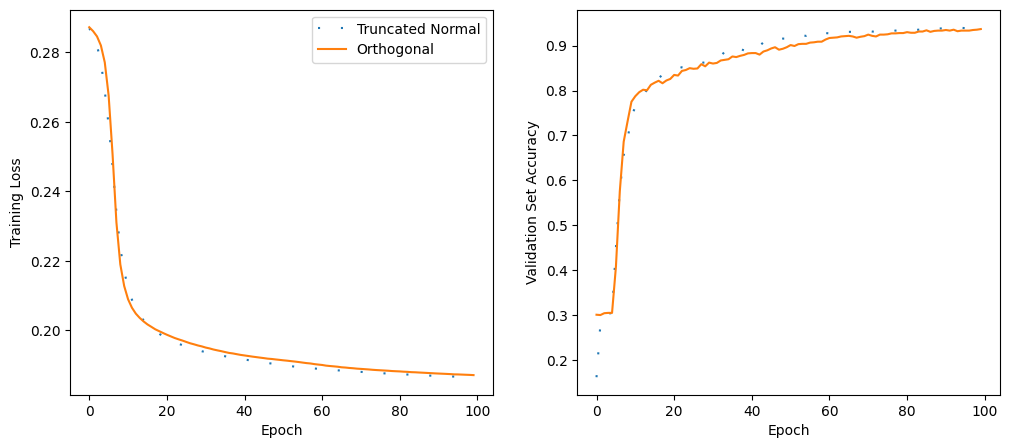

In [129]:
# Can Orthogonal and Truncated Normal converge to a better accuracy with more epochs?

LEARN_RATE = 1e-2
BATCH_SIZE = 32
EPOCHS = 100


# Orthogonal initialization
model = LocallyConnectedNeuralNetwork().to(device)
orthogonal_loss, orthogonal_accuracy = initialize_and_train_lc(model, torch.nn.init.orthogonal_, train_dataloader, val_dataloader, EPOCHS)
# Truncated normal initialization
model = LocallyConnectedNeuralNetwork().to(device)
truncated_normal_loss, truncated_normal_accuracy = initialize_and_train_lc(model, torch.nn.init.trunc_normal_, train_dataloader, val_dataloader, EPOCHS, a=-0.1, b=0.1)

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(truncated_normal_loss, label="Truncated Normal", linestyle=(0,(1,10)))
ax[0].plot(orthogonal_loss, label="Orthogonal")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Training Loss")
ax[0].legend()

ax[1].plot(truncated_normal_accuracy, label="Truncated Normal", linestyle=(0,(1,10)))
ax[1].plot(orthogonal_accuracy, label="Orthogonal")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Set Accuracy")
# ax[1].legend(ncol=3, bbox_to_anchor=(0.5,0.3), loc='center')
#plt.savefig('../initialization_comparison_lc.eps', format='eps')

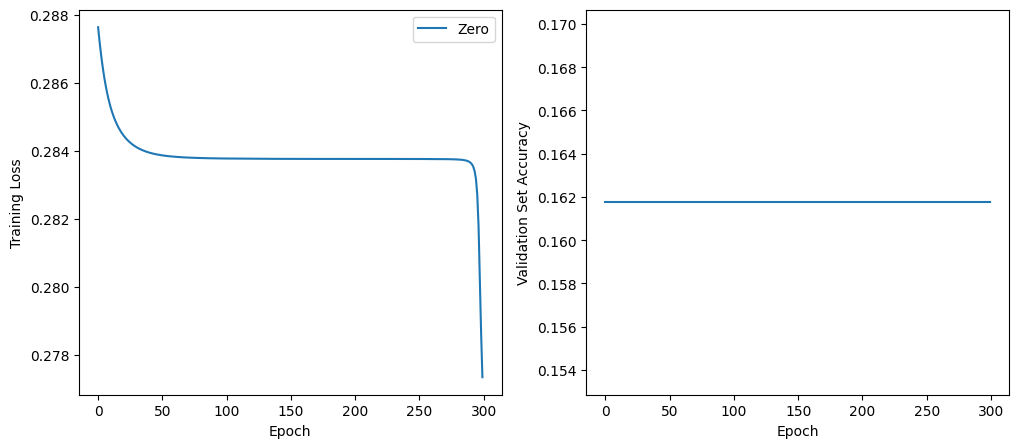

In [132]:
# How about zero initialization?

LEARN_RATE = 1e-2
BATCH_SIZE = 32
EPOCHS = 1000

# Zero initialization
model = LocallyConnectedNeuralNetwork().to(device)
zero_loss, zero_accuracy = initialize_and_train_lc(model, torch.nn.init.zeros_, train_dataloader, val_dataloader, EPOCHS)

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(zero_loss, label="Zero")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Training Loss")
ax[0].legend()

ax[1].plot(zero_accuracy, label="Zero")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Set Accuracy")
# ax[1].legend(ncol=3, bbox_to_anchor=(0.5,0.3), loc='center')
#plt.savefig('../initialization_comparison_lc.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


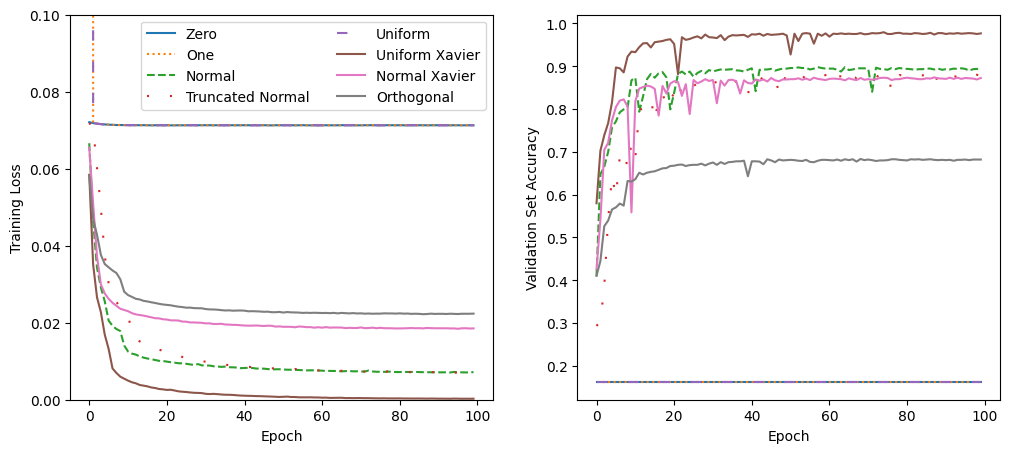

In [142]:
"""
We will work on the convolutional neural network.
"""

LEARN_RATE = 1e-2
BATCH_SIZE = 32
EPOCHS = 100


def initialize_and_train_conv(model, init_func, train_dataloader, val_dataloader, epochs, **init_params):
    """ Initialize the model and train it.

    Args:
        model: the model to train.
        loss_fn: the loss function to use.
        init_strat: the initialization function to use. It should take a model parameter as input and initialize it in place.
        train_dataloader: the dataloader for the training dataset.
        val_dataloader: the dataloader for the validation dataset.
        optimizer: the optimizer to use.
        epochs: the number of epochs to train the model.
        **init_params: the parameters to pass to the initialization function.

    Returns:
        loss: the training loss at each epoch.
        accuracy: the accuracy at each epoch.
    """
    init_func(model.conv1.weight, **init_params)
    init_func(model.conv2.weight, **init_params)
    init_func(model.fc1.weight, **init_params)
    init_func(model.fc2.weight, **init_params)

    model.conv1.bias.data.fill_(0.01)
    model.conv2.bias.data.fill_(0.01)
    model.fc1.bias.data.fill_(0.01)
    model.fc2.bias.data.fill_(0.01)

    loss = []
    accuracy = []

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARN_RATE) # Fixed learning rate for simplicity

    for epoch in range(epochs):
        loss.append(train(train_dataloader, model, loss_fn, optimizer))
        accuracy.append(test(val_dataloader, model, loss_fn))
    return loss, accuracy

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Zero initialization
model = ConvNet().to(device)
zero_loss, zero_accuracy = initialize_and_train_conv(model, torch.nn.init.zeros_, train_dataloader, val_dataloader, EPOCHS)

# One initialization
model = ConvNet().to(device)
one_loss, one_accuracy = initialize_and_train_conv(model, torch.nn.init.ones_, train_dataloader, val_dataloader, EPOCHS)

# Normal Initialization
model = ConvNet().to(device)
normal_loss, normal_accuracy = initialize_and_train_conv(model, torch.nn.init.normal_, train_dataloader, val_dataloader, EPOCHS, std=0.1)

# Truncated normal initialization
model = ConvNet().to(device)
truncated_normal_loss, truncated_normal_accuracy = initialize_and_train_conv(model, torch.nn.init.trunc_normal_, train_dataloader, val_dataloader, EPOCHS, a=-0.1, b=0.1)

# Uniform Initialization
model = ConvNet().to(device)
uniform_loss, uniform_accuracy = initialize_and_train_conv(model, torch.nn.init.uniform_, train_dataloader, val_dataloader, EPOCHS)

# Uniform Xavier initialization
model = ConvNet().to(device)
uniform_xavier_loss, uniform_xavier_accuracy = initialize_and_train_conv(model, torch.nn.init.xavier_uniform_, train_dataloader, val_dataloader, EPOCHS)

# Normal Xavier initialization
model = ConvNet().to(device)
normal_xavier_loss, normal_xavier_accuracy = initialize_and_train_conv(model, torch.nn.init.xavier_normal_, train_dataloader, val_dataloader, EPOCHS)

# Orthogonal initialization
model = ConvNet().to(device)
orthogonal_loss, orthogonal_accuracy = initialize_and_train_conv(model, torch.nn.init.orthogonal_, train_dataloader, val_dataloader, EPOCHS)

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(zero_loss, label="Zero")
ax[0].plot(one_loss, label="One", linestyle='dotted')
ax[0].plot(normal_loss, label="Normal", linestyle='dashed')
ax[0].plot(truncated_normal_loss, label="Truncated Normal", linestyle=(0,(1,10)))
ax[0].plot(uniform_loss, label="Uniform", linestyle=(0,(5,10)))
ax[0].plot(uniform_xavier_loss, label="Uniform Xavier")
ax[0].plot(normal_xavier_loss, label="Normal Xavier")
ax[0].plot(orthogonal_loss, label="Orthogonal")
ax[0].set_xlabel("Epoch")
ax[0].set_ylim([0.0, 0.1])
ax[0].set_ylabel("Training Loss")
ax[0].legend(ncol=2)

ax[1].plot(zero_accuracy, label="Zero")
ax[1].plot(one_accuracy, label="One", linestyle='dotted')
ax[1].plot(normal_accuracy, label="Normal", linestyle='dashed')
ax[1].plot(truncated_normal_accuracy, label="Truncated Normal", linestyle=(0,(1,10)))
ax[1].plot(uniform_accuracy, label="Uniform", linestyle=(0,(5,10)))
ax[1].plot(uniform_xavier_accuracy, label="Uniform Xavier")
ax[1].plot(normal_xavier_accuracy, label="Normal Xavier")
ax[1].plot(orthogonal_accuracy, label="Orthogonal")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Validation Set Accuracy")
# ax[1].legend(ncol=3, bbox_to_anchor=(0.5,0.3), loc='center')
plt.savefig('../initialization_comparison_conv.eps', format='eps')